In [1]:
%cd ../src/

/home/folgert/projects/nnfit/src


In [2]:
%run nets.py
%run simulation.py
%run dataset.py
%run utils.py
%run fit.py

In [3]:
import torch

In [4]:
def load_model(n_agents, varying_start_value, timesteps, distortion, fiv, model, lr):
    start = "vstart" if varying_start_value else "fstart"
    distortion = "_distortion" if distortion else ""
    fiv = "_fiv" if fiv else ""
    path = f'../results/{n_agents}_{start}_{timesteps}{distortion}{fiv}_{model}_{lr}.pt'
    if model == "RESNET":
        model = ResNet(1)
    elif model == "FCN":
        model = FCN(1, 1)
    elif model == "INCEPTION":
        model = InceptionTime(1, 1)
    model.load_state_dict(torch.load(path))
    return model

def get_bins(timesteps, min_bin_length=4):
    bins = {}
    maxlen = np.ceil(timesteps / min_bin_length)
    for i in range(1, int(maxlen + 1)):
        bins[i] = int(np.ceil(timesteps / i))
    bins = np.array(sorted(set(bins.values())))
    return bins

In [84]:
import collections
import numpy as np
import pandas as pd
import tqdm

# (n_agents, timesteps, varying_start_value, 
#  distortion, fiv, model, lr) = 10000, 500, True, False, False, "FCN", 6e-5
# model = load_model(n_agents, varying_start_value, timesteps, distortion, fiv, model, lr)
# model.eval()
model = InceptionTime(1, 1)
# model.load_state_dict(torch.load("../results/a3007964.pt")["state_dict"]) # good one
# model.load_state_dict(torch.load("../results/32a610b0.pt")["state_dict"]) # good one
# model.load_state_dict(torch.load("../results/87ae1186.pt")["state_dict"]) # OK one
model.load_state_dict(torch.load("../results/8b3ca1bc.pt")["state_dict"])

timesteps = 500
n_agents = 5000

device = torch.device("cuda")
model.to(device)
model.eval()

bins = get_bins(timesteps)

n_reps = 100

# selection_values = np.array(sorted(np.concatenate(([0], loguniform(0.001, 1, 200 - 1)))))
selection_values = np.concatenate(
   ([0], np.exp(np.linspace(np.log(0.001), np.log(1), 200 - 1))))

In [85]:
nn_results, fit_results = [], []

for rep in tqdm.trange(n_reps):
    data_dict = collections.defaultdict(list)
    for i, selection in enumerate(selection_values):
        data = wright_fisher(n_agents, timesteps, selection, start=0.5)
        for bin_size in bins:
            binned_data = apply_binning(data, bin_size, n_agents)
            x = np.array(binned_data)
            x = (x - x.mean()) / x.std()
            data_dict[bin_size].append((selection, torch.FloatTensor(x)))
            
            # Perform the FIT test
            fit = frequency_increment_test(np.arange(1, len(binned_data) + 1), binned_data)
            fit.update({
                "selection": selection,
                "bin": bin_size,
            })
            fit_results.append(fit)
            
    for bin_size, data in data_dict.items():
        selection, data = zip(*data)
        data = torch.stack(data).unsqueeze(1).to(device)
        with torch.no_grad():
            probs = torch.sigmoid(model(data)).cpu().numpy().squeeze(1)
            preds = probs > 0.5
            for i, pred in enumerate(preds.tolist()):
                nn_results.append({
                    "selection": selection[i],
                    "bin": bin_size,
                    "pred": pred,
                    "prob": probs[i]
                })

100%|██████████| 100/100 [15:50<00:00,  9.51s/it]


In [86]:
nn_df = pd.DataFrame(nn_results)
fit_df = pd.DataFrame(fit_results)

In [87]:
nn_df['FP'] = (nn_df['selection'] == 0) & (nn_df['pred'] == True)
nn_df['FN'] = (nn_df['selection'] > 0) & (nn_df['pred'] != True)
nn_df['F'] = nn_df["FN"] | nn_df["FP"]
nn_df["y_true"] = (nn_df["selection"] > 0).astype(int)
nn_df.head()

,selection,bin,pred,prob,FP,FN,F,y_true
0,0.000000,4,True,9.903595e-01,True,False,True,0
1,0.001000,4,False,1.224853e-09,False,True,True,1
2,0.001036,4,True,9.999999e-01,False,False,False,1
3,0.001072,4,True,1.000000e+00,False,False,False,1
4,0.001110,4,True,1.000000e+00,False,False,False,1


In [88]:
fit_df['FP'] = ((fit_df['selection'] == 0) & (fit_df['Tp'] < 0.05)) 
fit_df['FN'] = ((fit_df['selection'] > 0) & (fit_df['Tp'] > 0.05)) 
fit_df['F'] = fit_df["FN"] | fit_df["FP"]
fit_df['pred'] = fit_df['Tp'] < 0.05
fit_df['y_true'] = (fit_df['selection'] > 0).astype(int)
fit_df['normal'] = 1
fit_df.loc[fit_df['Wp'] < 0.05, 'normal'] = np.nan
fit_df.head()

,T,Tp,W,Wp,selection,bin,FP,FN,F,pred,y_true,normal
0,1.009006,0.419199,0.947270,0.557488,0.0,4,False,False,False,False,0,1.0
1,1.215963,0.310951,0.966703,0.820973,0.0,5,False,False,False,False,0,1.0
2,1.158125,0.311251,0.837814,0.158969,0.0,6,False,False,False,False,0,1.0
3,0.941515,0.389669,0.859524,0.187538,0.0,7,False,False,False,False,0,1.0
4,0.978213,0.365747,0.921902,0.484316,0.0,8,False,False,False,False,0,1.0


In [89]:
from sklearn.metrics import classification_report

print(classification_report(
    fit_df.loc[fit_df["selection"] < 1, 'y_true'].values, 
    fit_df.loc[fit_df["selection"] < 1, 'pred'].values))

              precision    recall  f1-score   support

           0       0.01      0.90      0.02      4100
           1       1.00      0.49      0.65    811800

    accuracy                           0.49    815900
   macro avg       0.50      0.69      0.34    815900
weighted avg       0.99      0.49      0.65    815900



In [90]:
print(classification_report(
    nn_df.loc[nn_df["selection"] < 1, 'y_true'].values, 
    nn_df.loc[nn_df["selection"] < 1, 'pred'].values))

              precision    recall  f1-score   support

           0       0.06      0.80      0.12      4100
           1       1.00      0.94      0.97    811800

    accuracy                           0.94    815900
   macro avg       0.53      0.87      0.54    815900
weighted avg       0.99      0.94      0.96    815900



In [91]:
print(nn_df.loc[(nn_df["selection"] < 1), "F"].mean())
print(fit_df.loc[(fit_df["selection"] < 1), "F"].mean())

0.05960044123054296
0.5117306042407158


In [92]:
import matplotlib.pyplot as plt
import seaborn.cm as cm

def plot_heat(df, ax=None, ylabel=None, title=None, mask=None):
    if ax is None:
        fig, ax = plt.subplots()
        
    if mask is not None:
        df[mask] = np.nan
    
    img = ax.imshow(
        df, aspect="auto", cmap=cm.rocket, vmin=0, vmax=1)
    
    # correct x-ticks
    ticks = np.exp(np.linspace(np.log(0.001), np.log(1), 4))
    locs = np.where(np.isin(selection_values, ticks))[0]
    print(locs)
    ax.set_xticks(locs)
    ax.set_xticklabels([f'{s:.13g}' for s in ticks])
    
    # correct y-ticks
    ax.set_yticks(np.arange(bins.shape[0]))
    ax.set_yticklabels(bins)
    
    # Set labels
    ax.set(xlabel="selection strength", ylabel=ylabel, title=title)
    return ax, img

[  1  67 133 199]
[  1  67 133 199]
[  1  67 133 199]


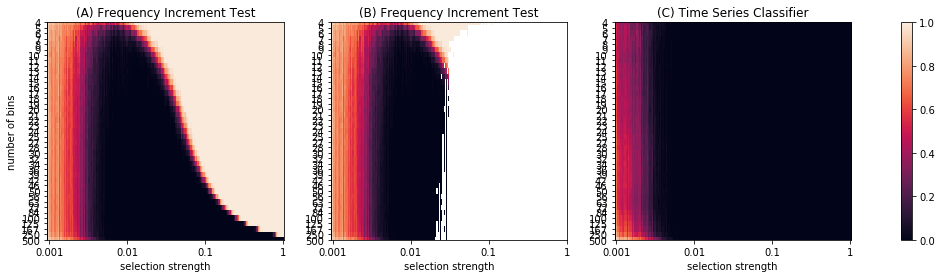

In [93]:
fig, (fit_ax, fit_norm_ax, nn_ax) = plt.subplots(ncols=3, figsize=(18, 4))

F = fit_df.groupby(["selection", "bin"])["FN"].mean().unstack().T
ax, img = plot_heat(F, ax=fit_ax, title="(A) Frequency Increment Test", ylabel="number of bins")

F = (fit_df.groupby(["selection", "bin"])["FN"].mean().unstack().T * 
     fit_df.groupby(["selection", "bin"])["normal"].mean().unstack().T)
ax, img = plot_heat(F, ax=fit_norm_ax, title="(B) Frequency Increment Test")

F = nn_df.groupby(["selection", "bin"])["FN"].mean().unstack().T
ax, img = plot_heat(F, ax=nn_ax, title="(C) Time Series Classifier")

fig.colorbar(img, ax=(fit_ax, fit_norm_ax, nn_ax))

plt.savefig("../plots/selection_over_bin.png", transparent=True, dpi=300)
plt.savefig("../plots/selection_over_bin.pdf", bbox_inches = 'tight', dpi=300)

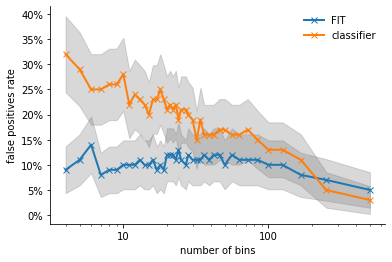

In [100]:
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import scipy.stats

def mean_confidence_interval(data, confidence=0.89):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m+h

def plot_bin_error(df, ax=None, label=None):
    if ax is None:
        fig, ax = plt.subplots()
    x = df.loc[(df['selection'] == 0), ['bin', 'FP']].astype(
        int).groupby('bin')['FP'].agg(mean=np.mean, ci=mean_confidence_interval).values
    mean = x[:, 0]
    ci = np.array(x[:, 1].tolist())
    ax.plot(bins, mean, '-x', label=label, lw=2)
    ax.fill_between(bins, ci[:, 0], ci[:, 1], alpha=0.3, color="grey")
    ax.set(xlabel="number of bins", ylabel="false positives rate")
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
    return ax

fig, ax = plt.subplots(figsize=(6, 4))
plot_bin_error(fit_df, ax=ax, label="FIT")
plot_bin_error(nn_df, ax=ax, label="classifier")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False);

plt.savefig("../plots/FP-rate.png", dpi=300, transparent=True)
plt.savefig("../plots/FP-rate.pdf", dpi=300)

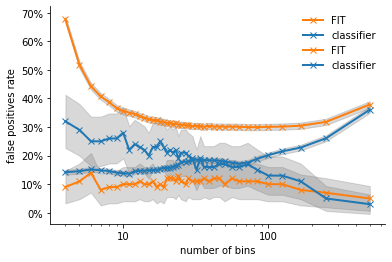

In [108]:
from matplotlib.ticker import ScalarFormatter, FuncFormatter
import scipy.stats

def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m-h, m+h

def plot_bin_error(df, type, ax=None, label=None, color=None):
    if ax is None:
        fig, ax = plt.subplots()
    if type == "FN":
        x = df.loc[(df['selection'] > 0) & (df['selection'] < 0.01), ['bin', 'FN']].astype(
            int).groupby('bin')['FN'].agg(mean=np.mean, ci=mean_confidence_interval).values
    else:
        x = df.loc[(df['selection'] == 0), ['bin', 'FP']].astype(
        int).groupby('bin')['FP'].agg(mean=np.mean, ci=mean_confidence_interval).values
    mean = x[:, 0]
    ci = np.array(x[:, 1].tolist())
    ax.plot(bins, mean, '-x', label=label, lw=2, color=color)
    ax.fill_between(bins, ci[:, 0], ci[:, 1], alpha=0.3, color="grey")
    ax.set(xlabel="number of bins", ylabel="false positives rate")
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
    return ax

fig, ax = plt.subplots(figsize=(6, 4))
plot_bin_error(fit_df, "FP", ax=ax, label="FIT", color="C1")
plot_bin_error(nn_df, "FP", ax=ax, label="classifier", color="C0")
plot_bin_error(fit_df, "FN", ax=ax, label="FIT", color="C1")
plot_bin_error(nn_df, "FN", ax=ax, label="classifier", color="C0")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False);

plt.savefig("../plots/FN-rate.png", dpi=300, transparent=True)
plt.savefig("../plots/FN-rate.pdf", dpi=300)

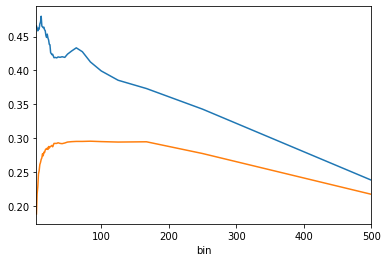

In [109]:
from sklearn.metrics import f1_score

nn_df[nn_df['selection'] < 0.002].groupby('bin')[['y_true', 'pred']].apply(
    lambda x: f1_score(x.values.astype(int).T[0], x.values.astype(int).T[1], average="macro")).plot()
fit_df[fit_df['selection'] < 0.002].groupby('bin')[['y_true', 'pred']].apply(
    lambda x: f1_score(x.values.astype(int).T[0], x.values.astype(int).T[1], average="macro")).plot()

In [1]:
!ulimit -n

4096


In [58]:
import matplotlib.pyplot as plt

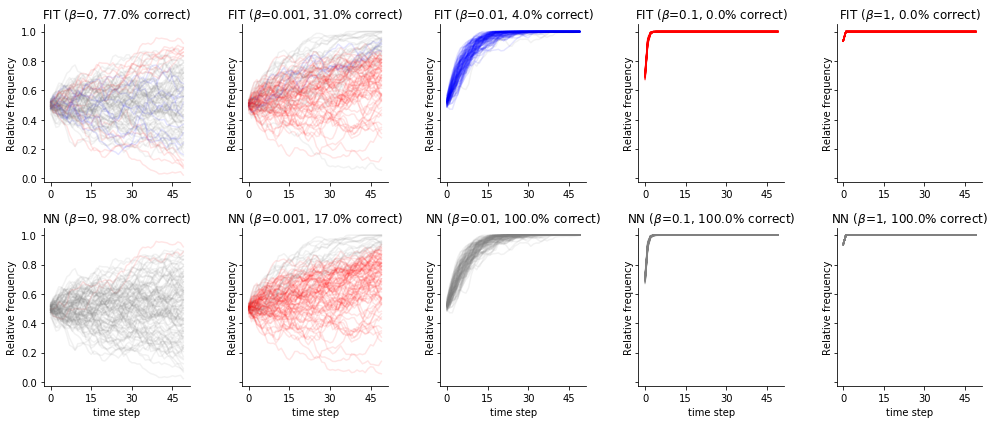

In [24]:
# (n_agents, timesteps, varying_start_value, 
#  distortion, fiv, model, lr) = 10000, 200, True, False, False, "RESNET", 6e-5
# model = load_model(n_agents, varying_start_value, timesteps, distortion, fiv, model, lr)
# model.eval()

# device = torch.device("cuda")
# model.to(device)

fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(14, 6), sharey=True)

for i, selection in enumerate((0, 0.001, 0.01, 0.1, 1)):
    fit_accuracy, nn_accuracy = 0, 0
    batch = []
    for rep in range(100):
        data = wright_fisher(n_agents, timesteps, selection, start=0.5)

        binned_data = apply_binning(data, 50, n_agents)
        batch.append(binned_data)
        fit = frequency_increment_test(np.arange(1, len(binned_data) + 1), binned_data)
        color = ('red' if (fit['Tp'] < 0.05 and selection == 0) else 
                 'red' if (selection > 0 and fit['Tp'] > 0.05) else
                 'blue' if (fit['Wp'] < 0.05) else
                 'grey')
        
        if color == 'grey':
            fit_accuracy += 1
                    
        if rep <= 100:
            axes[0, i].plot(binned_data, color=color, alpha=0.1)

    with torch.no_grad():
        prob = torch.sigmoid(
            model(torch.FloatTensor(batch).unsqueeze(1).to(device))
        ).cpu().numpy().squeeze(1)
        pred = prob > 0.5
        for j, sample in enumerate(batch):
            color = ('red' if (pred[j] and selection == 0) else 
                     'red' if (selection > 0 and not pred[j]) else
                     'grey')

            if color == "grey":
                nn_accuracy += 1

#             if rep <= 100:
            axes[1, i].plot(sample, color=color, alpha=0.1)

    axes[0, i].set_ylabel("Relative frequency")
    axes[0, i].spines['top'].set_visible(False)
    axes[0, i].spines['right'].set_visible(False)
    axes[0, i].set_title(f'FIT ($\\beta$={selection}, {fit_accuracy/100:.1%} correct)')
    axes[0, i].xaxis.set_major_locator(plt.MaxNLocator(4))
    
    axes[1, i].set_xlabel("time step")
    axes[1, i].set_ylabel("Relative frequency")
    axes[1, i].spines['top'].set_visible(False)
    axes[1, i].spines['right'].set_visible(False)
    axes[1, i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axes[1, i].set_title(f'NN ($\\beta$={selection}, {nn_accuracy/100:.1%} correct)')

plt.tight_layout()
plt.savefig("../plots/fixed-bin-varying-selection.png", transparent=True, dpi=300)
plt.savefig("../plots/fixed-bin-varying-selection.pdf", dpi=300)

In [33]:
torch.FloatTensor(batch)

tensor([[0.5000, 0.4992, 0.4932,  ..., 0.4828, 0.4893, 0.4982],
        [0.5000, 0.5088, 0.5017,  ..., 0.6002, 0.6006, 0.6035],
        [0.5000, 0.4926, 0.4940,  ..., 0.4601, 0.4614, 0.4613],
        ...,
        [0.5000, 0.4989, 0.5046,  ..., 0.4672, 0.4713, 0.4699],
        [0.5000, 0.5022, 0.5037,  ..., 0.6161, 0.6099, 0.6063],
        [0.5000, 0.4962, 0.4908,  ..., 0.5727, 0.5700, 0.5719]])

## Unbiased Drift disguised as selection

In [774]:
n_agents, timesteps, varying_start_value, distortion = 10000, 200, False, False
model = load_model(n_agents, varying_start_value, timesteps, distortion)
model.eval()

device = torch.device("cuda")
model.to(device)

bins = get_bins(timesteps)

n_reps = 10000

nn_results_unbiased, fit_results_unbiased = [], []
selection_base = 0.0

for rep in tqdm.trange(n_reps):
    data_dict = collections.defaultdict(list)
    data = wright_fisher(n_agents, timesteps, selection_base, start=0.5)
    for bin_size in bins:
        binned_data = apply_binning(data, bin_size, n_agents)
        data_dict[bin_size].append((selection_base, torch.FloatTensor(binned_data)))
            
        # Perform the FIT test
        fit = frequency_increment_test(np.arange(1, len(binned_data) + 1), binned_data)
        fit.update({
            "selection": selection_base,
            "bin": bin_size,
            "data": binned_data,
        })
        fit_results_unbiased.append(fit)
            
    for bin_size, data in data_dict.items():
        selection, data = zip(*data)
        data = torch.stack(data).unsqueeze(1).to(device)
        with torch.no_grad():
            probs = torch.sigmoid(model(data)).cpu().numpy().squeeze(1)
            preds = probs > 0.5
            for i, pred in enumerate(preds.tolist()):
                nn_results_unbiased.append({
                    "selection": selection[i],
                    "bin": bin_size,
                    "pred": pred,
                    "prob": probs[i],
                    "data": data[i].cpu().numpy(),
                })

100%|██████████| 10000/10000 [13:38<00:00, 12.22it/s]


In [775]:
fit_results_unbiased_df = pd.DataFrame(fit_results_unbiased)

In [776]:
fit_results_unbiased_df.head()

,T,Tp,W,Wp,selection,bin,data
0,1.170076,0.362532,0.968994,0.661939,0.0,4,"[0.520966, 0.510434, 0.532998, 0.572926]"
1,1.385895,0.259831,0.959582,0.776279,0.0,5,"[0.51671, 0.5100925, 0.5315875, 0.5345875, 0.5..."
2,1.360811,0.245199,0.941777,0.678531,0.0,6,"[0.5147382352941177, 0.5263205882352942, 0.505..."
3,0.997722,0.364220,0.902869,0.391168,0.0,7,"[0.5133586206896552, 0.530548275862069, 0.4953..."
4,1.401984,0.210478,0.890127,0.275326,0.0,8,"[0.51028, 0.531652, 0.507228, 0.51364, 0.53642..."


In [777]:
fit_results_unbiased_df['FP'] = fit_results_unbiased_df['Tp'] < 0.05
fit_results_unbiased_df['pred'] = fit_results_unbiased_df['Tp'] < 0.05
fit_results_unbiased_df['normal'] = 1
fit_results_unbiased_df.loc[fit_results_unbiased_df['Wp'] < 0.05, 'normal'] = np.nan
fit_results_unbiased_df.head()

,T,Tp,W,Wp,selection,bin,data,FP,pred,normal
0,1.170076,0.362532,0.968994,0.661939,0.0,4,"[0.520966, 0.510434, 0.532998, 0.572926]",False,False,1.0
1,1.385895,0.259831,0.959582,0.776279,0.0,5,"[0.51671, 0.5100925, 0.5315875, 0.5345875, 0.5...",False,False,1.0
2,1.360811,0.245199,0.941777,0.678531,0.0,6,"[0.5147382352941177, 0.5263205882352942, 0.505...",False,False,1.0
3,0.997722,0.364220,0.902869,0.391168,0.0,7,"[0.5133586206896552, 0.530548275862069, 0.4953...",False,False,1.0
4,1.401984,0.210478,0.890127,0.275326,0.0,8,"[0.51028, 0.531652, 0.507228, 0.51364, 0.53642...",False,False,1.0


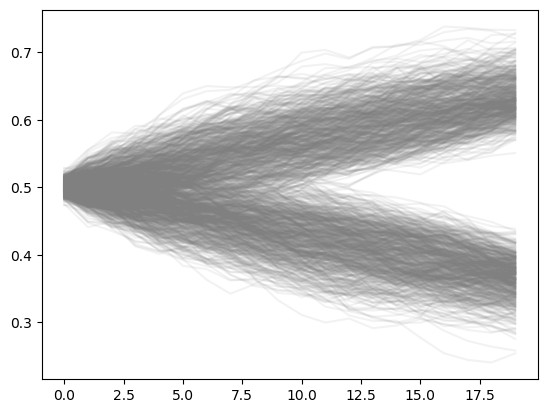

In [789]:
fig, ax = plt.subplots()

for sample in np.vstack(
    fit_results_unbiased_df[
        fit_results_unbiased_df['FP'] & 
        (fit_results_unbiased_df['bin'] == 20)
    ]['data'].values):
    ax.plot(sample, color="grey", alpha=0.1)

In [783]:
nn_results_unbiased_df = pd.DataFrame(nn_results_unbiased)

In [784]:
nn_results_unbiased_df['FP'] = nn_results_unbiased_df['pred'] == True

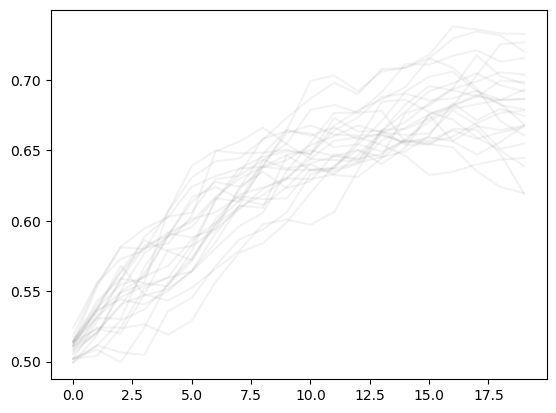

In [790]:
fig, ax = plt.subplots()

for sample in np.vstack(
    nn_results_unbiased_df[
        nn_results_unbiased_df['FP'] & 
        (nn_results_unbiased_df['bin'] == 20)
    ]['data'].values):
    ax.plot(sample, color="grey", alpha=0.1)

## Varying start values

In [15]:
n_agents, timesteps, varying_start_value, distortion = 10000, 200, True, False
model = load_model(n_agents, varying_start_value, timesteps, distortion)
model.eval()

device = torch.device("cuda")
model.to(device)

bins = get_bins(timesteps)

n_reps = 1000

selection_values = np.concatenate(
    ([0], np.exp(np.linspace(np.log(0.001), np.log(1), timesteps - 1))))

nnv_results, fitv_results = [], []

for rep in tqdm.trange(n_reps):
    data_dict = collections.defaultdict(list)
    for i, selection in enumerate(selection_values):
        data = wright_fisher(n_agents, timesteps, selection, start=0.5)
        for bin_size in bins:
            binned_data = apply_binning(data, bin_size, n_agents)
            data_dict[bin_size].append((selection, torch.FloatTensor(binned_data)))
            
            # Perform the FIT test
            fit = frequency_increment_test(np.arange(1, len(binned_data) + 1), binned_data)
            fit.update({
                "selection": selection,
                "bin": bin_size,
            })
            fitv_results.append(fit)
            
    for bin_size, data in data_dict.items():
        selection, data = zip(*data)
        data = torch.stack(data).unsqueeze(1).to(device)
        with torch.no_grad():
            probs = torch.sigmoid(model(data)).cpu().numpy().squeeze(1)
            preds = probs > 0.5
            for i, pred in enumerate(preds.tolist()):
                nnv_results.append({
                    "selection": selection[i],
                    "bin": bin_size,
                    "pred": pred,
                    "prob": probs[i]
                })

100%|██████████| 1000/1000 [1:00:21<00:00,  3.62s/it]


In [16]:
nnv_df = pd.DataFrame(nnv_results)
fitv_df = pd.DataFrame(fitv_results)

In [17]:
nnv_df['FP'] = (nnv_df['selection'] == 0) & (nnv_df['pred'] == True)
nnv_df['FN'] = (nnv_df['selection'] > 0) & (nnv_df['pred'] != True)
nnv_df['F'] = nnv_df["FN"] | nnv_df["FP"]
nnv_df.head()

,selection,bin,pred,prob,FP,FN,F
0,0.000000,4,True,0.537625,True,False,True
1,0.001000,4,True,0.820718,False,False,False
2,0.001036,4,True,0.913409,False,False,False
3,0.001072,4,True,0.990265,False,False,False
4,0.001110,4,False,0.244858,False,True,True


In [18]:
fitv_df['FP'] = (fitv_df['selection'] == 0) & (fitv_df['Tp'] < 0.05)
fitv_df['FN'] = (fitv_df['selection'] > 0) & (fitv_df['Tp'] > 0.05)
fitv_df['F'] = fitv_df["FN"] | fitv_df["FP"]
fitv_df['pred'] = fitv_df['Tp'] < 0.05
fitv_df['normal'] = 1
fitv_df.loc[fitv_df['Wp'] < 0.05, 'normal'] = np.nan
fitv_df.head()

,T,Tp,W,Wp,selection,bin,FP,FN,F,pred,normal
0,-1.450045,0.284103,0.967942,0.656192,0.0,4,False,False,False,False,1.0
1,-1.163176,0.328869,0.994798,0.980562,0.0,5,False,False,False,False,1.0
2,-1.011250,0.369098,0.871206,0.271340,0.0,6,False,False,False,False,1.0
3,-0.918327,0.400578,0.930994,0.587802,0.0,7,False,False,False,False,1.0
4,-0.970525,0.369266,0.940183,0.640370,0.0,8,False,False,False,False,1.0


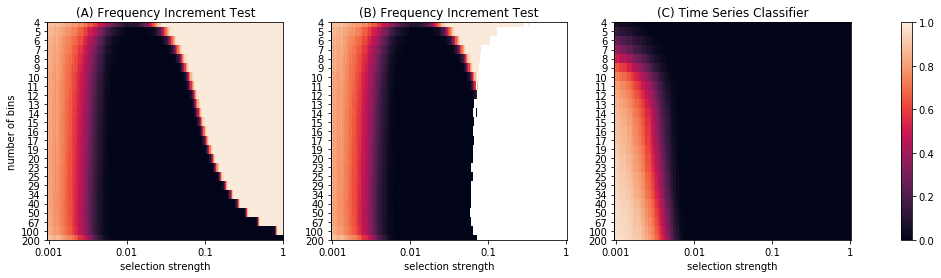

In [59]:
fig, (fit_ax, fit_norm_ax, nn_ax) = plt.subplots(ncols=3, figsize=(18, 4))

F = fitv_df.groupby(["selection", "bin"])["FN"].mean().unstack().T
ax, img = plot_heat(F, ax=fit_ax, title="(A) Frequency Increment Test", ylabel="number of bins")

F = (fitv_df.groupby(["selection", "bin"])["FN"].mean().unstack().T * 
     fitv_df.groupby(["selection", "bin"])["normal"].mean().unstack().T)
ax, img = plot_heat(F, ax=fit_norm_ax, title="(B) Frequency Increment Test")

F = nnv_df.groupby(["selection", "bin"])["FN"].mean().unstack().T
ax, img = plot_heat(F, ax=nn_ax, title="(C) Time Series Classifier")

fig.colorbar(img, ax=(fit_ax, fit_norm_ax, nn_ax))

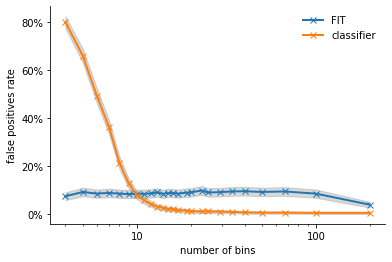

In [22]:
def plot_bin_error(df, ax=None, label=None):
    if ax is None:
        fig, ax = plt.subplots()
    x = df.loc[df['selection'] == 0, ['bin', 'FP']].astype(
        int).groupby('bin')['FP'].agg(mean=np.mean, ci=mean_confidence_interval).values
    mean = x[:, 0]
    ci = np.array(x[:, 1].tolist())
    ax.plot(bins, mean, '-x', label=label, lw=2)
    ax.fill_between(bins, ci[:, 0], ci[:, 1], alpha=0.3, color="grey")
    ax.set(xlabel="number of bins", ylabel="false positives rate")
    ax.set_xscale('log')
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
    return ax

fig, ax = plt.subplots(figsize=(6, 4))
plot_bin_error(fitv_df, ax=ax, label="FIT")
plot_bin_error(nnv_df, ax=ax, label="classifier")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.legend(frameon=False);

In [124]:
nnv_df['F'].sum() / nnv_df.shape[0]

0.1231308

In [41]:
fitv_df['F'].sum() / fitv_df.shape[0]

0.4472688

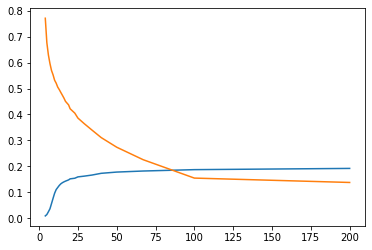

In [46]:
plt.plot(nnv_df.groupby('bin').apply(lambda x: x['F'].sum() / x.shape[0]))
plt.plot(fitv_df.groupby('bin').apply(lambda x: x['F'].sum() / x.shape[0]))

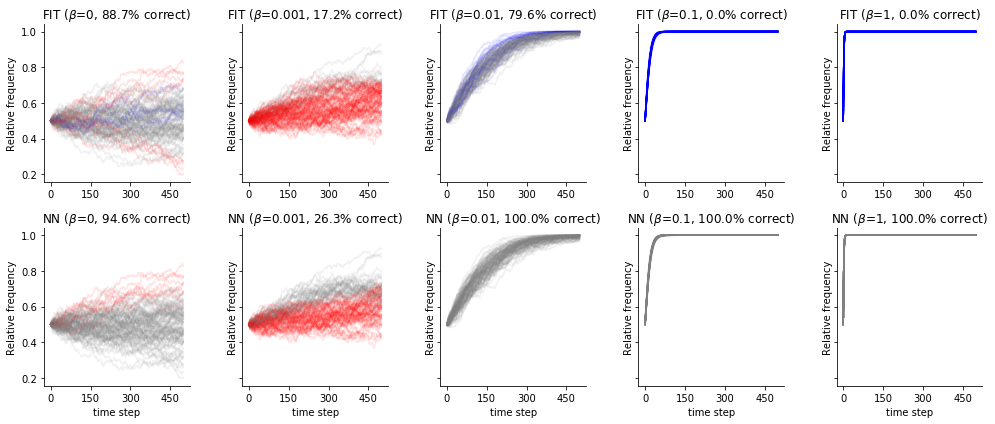

In [58]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(14, 6), sharey=True)

for i, selection in enumerate((0, 0.001, 0.01, 0.1, 1)):
    fit_accuracy, nn_accuracy = 0, 0
    for rep in range(1000):
        data = wright_fisher(n_agents, 500, selection, start=0.5)

        binned_data = apply_binning(data, 500, n_agents)
        fit = frequency_increment_test(np.arange(1, len(binned_data) + 1), binned_data)
        color = ('red' if (fit['Tp'] < 0.05 and selection == 0) else 
                 'red' if (selection > 0 and fit['Tp'] > 0.05) else
                 'blue' if (fit['Wp'] < 0.05) else
                 'grey')
        
        if color == 'grey':
            fit_accuracy += 1
                    
        if rep <= 100:
            axes[0, i].plot(binned_data, color=color, alpha=0.1)

        with torch.no_grad():
            prob = torch.sigmoid(
                model(torch.FloatTensor([binned_data]).unsqueeze(1).to(device))
            ).cpu().numpy().squeeze(1)[0]
            pred = prob > 0.5
            color = ('red' if (pred and selection == 0) else 
                     'red' if (selection > 0 and not pred) else
                     'grey')
            
            if color == "grey":
                nn_accuracy += 1
            
            if rep <= 100:
                axes[1, i].plot(binned_data, color=color, alpha=0.1)

    axes[0, i].set_ylabel("Relative frequency")
    axes[0, i].spines['top'].set_visible(False)
    axes[0, i].spines['right'].set_visible(False)
    axes[0, i].set_title(f'FIT ($\\beta$={selection}, {fit_accuracy/1000:.1%} correct)')
    axes[0, i].xaxis.set_major_locator(plt.MaxNLocator(4))
    
    axes[1, i].set_xlabel("time step")
    axes[1, i].set_ylabel("Relative frequency")
    axes[1, i].spines['top'].set_visible(False)
    axes[1, i].spines['right'].set_visible(False)
    axes[1, i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axes[1, i].set_title(f'NN ($\\beta$={selection}, {nn_accuracy/1000:.1%} correct)')

plt.tight_layout()

## Frequency Increment Training

In [120]:
n_agents, timesteps, varying_start_value, distortion, fiv = 10000, 200, False, False, True
model = load_model(n_agents, varying_start_value, timesteps, distortion, fiv)
model.eval()

device = torch.device("cuda")
model.to(device)

bins = get_bins(timesteps)

n_reps = 1000

selection_values = np.concatenate(
    ([0], np.exp(np.linspace(np.log(0.001), np.log(1), timesteps - 1))))

../results/10000_fstart_200_fiv.pt


In [ ]:
nn_fiv_results, fit_fiv_results = [], []

for rep in tqdm.trange(n_reps):
    data_dict = collections.defaultdict(list)
    for i, selection in enumerate(selection_values):
        data = wright_fisher(n_agents, timesteps, selection, start=0.5)
        for bin_size in bins:
            binned_data = apply_binning(data, bin_size, n_agents)
            nn_data = frequency_increment_values(
                np.arange(1, len(binned_data) + 1), binned_data, clip=True)
            data_dict[bin_size].append((selection, torch.FloatTensor(nn_data)))
            
            # Perform the FIT test
            fit = frequency_increment_test(
                np.arange(1, len(binned_data) + 1), binned_data)
            fit.update({
                "selection": selection,
                "bin": bin_size,
            })
            fit_fiv_results.append(fit)
            
    for bin_size, data in data_dict.items():
        selection, data = zip(*data)
        data = torch.stack(data).unsqueeze(1).to(device)
        with torch.no_grad():
            probs = torch.sigmoid(model(data)).cpu().numpy().squeeze(1)
            preds = probs > 0.5
            for i, pred in enumerate(preds.tolist()):
                nn_fiv_results.append({
                    "selection": selection[i],
                    "bin": bin_size,
                    "pred": pred,
                    "prob": probs[i]
                })

 36%|███▋      | 365/1000 [26:56<49:31,  4.68s/it]  

In [123]:
nn_fiv_df = pd.DataFrame(nn_fiv_results)
fit_fiv_df = pd.DataFrame(fit_fiv_results)

In [125]:
nn_fiv_df['FP'] = (nn_fiv_df['selection'] == 0) & (nn_fiv_df['pred'] == True)
nn_fiv_df['FN'] = (nn_fiv_df['selection'] > 0) & (nn_fiv_df['pred'] != True)
nn_fiv_df['F'] = nn_fiv_df["FN"] | nn_fiv_df["FP"]
nn_fiv_df.head()

,selection,bin,pred,prob,FP,FN,F
0,0.000000,4,True,0.595179,True,False,True
1,0.001000,4,True,0.701564,False,False,False
2,0.001036,4,True,0.768058,False,False,False
3,0.001072,4,False,0.406506,False,True,True
4,0.001110,4,False,0.438523,False,True,True


In [126]:
nn_fiv_df['F'].sum() / nn_fiv_df.shape[0]

0.3140476

In [127]:
fit_fiv_df['FP'] = (fit_fiv_df['selection'] == 0) & (fit_fiv_df['Tp'] < 0.05)
fit_fiv_df['FN'] = (fit_fiv_df['selection'] > 0) & (fit_fiv_df['Tp'] > 0.05)
fit_fiv_df['F'] = fit_fiv_df["FN"] | fit_fiv_df["FP"]
fit_fiv_df['pred'] = fit_fiv_df['Tp'] < 0.05
fit_fiv_df['normal'] = 1
fit_fiv_df.loc[fit_fiv_df['Wp'] < 0.05, 'normal'] = np.nan
fit_fiv_df.head()

,T,Tp,W,Wp,selection,bin,FP,FN,F,pred,normal
0,2.511300,0.128663,0.985686,0.770956,0.0,4,False,False,False,False,1.0
1,3.504163,0.039363,0.912601,0.496289,0.0,5,True,False,True,True,1.0
2,2.521469,0.065255,0.977925,0.923228,0.0,6,False,False,False,False,1.0
3,2.288523,0.070780,0.908497,0.426585,0.0,7,False,False,False,False,1.0
4,2.288386,0.062081,0.986434,0.984697,0.0,8,False,False,False,False,1.0


In [128]:
fit_fiv_df['F'].sum() / fit_fiv_df.shape[0]

0.4466728

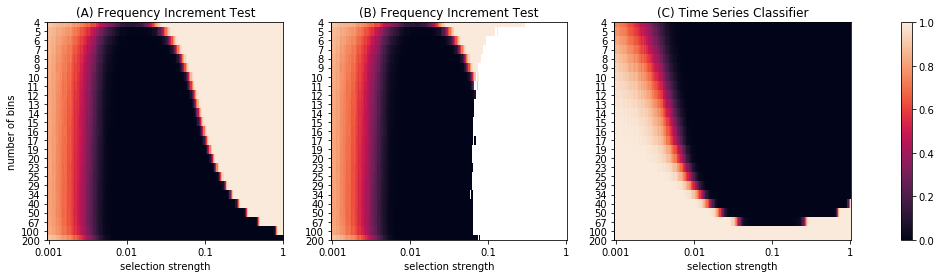

In [129]:
fig, (fit_ax, fit_norm_ax, nn_ax) = plt.subplots(ncols=3, figsize=(18, 4))

F = fit_fiv_df.groupby(["selection", "bin"])["FN"].mean().unstack().T
ax, img = plot_heat(F, ax=fit_ax, title="(A) Frequency Increment Test", ylabel="number of bins")

F = (fit_fiv_df.groupby(["selection", "bin"])["FN"].mean().unstack().T * 
     fit_fiv_df.groupby(["selection", "bin"])["normal"].mean().unstack().T)
ax, img = plot_heat(F, ax=fit_norm_ax, title="(B) Frequency Increment Test")

F = nn_fiv_df.groupby(["selection", "bin"])["FN"].mean().unstack().T
ax, img = plot_heat(F, ax=nn_ax, title="(C) Time Series Classifier")

fig.colorbar(img, ax=(fit_ax, fit_norm_ax, nn_ax))

../results/10000_fstart_200_fiv.pt


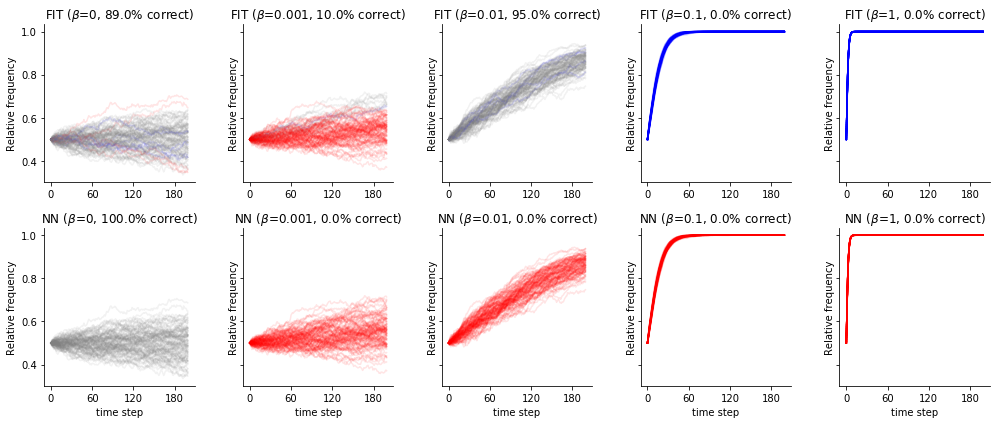

In [118]:
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(14, 6), sharey=True)

reps = 1000
for i, selection in enumerate((0, 0.001, 0.01, 0.1, 1)):
    fit_accuracy, nn_accuracy = 0, 0
    for rep in range(reps):
        data = wright_fisher(n_agents, timesteps, selection, start=0.5)

        binned_data = apply_binning(data, 200, n_agents)
        fit = frequency_increment_test(np.arange(1, len(binned_data) + 1), binned_data)
        color = ('red' if (fit['Tp'] < 0.05 and selection == 0) else 
                 'red' if (selection > 0 and fit['Tp'] > 0.05) else
                 'blue' if (fit['Wp'] < 0.05) else
                 'grey')
        
        if color == 'grey':
            fit_accuracy += 1
                    
        if rep <= 100:
            axes[0, i].plot(binned_data, color=color, alpha=0.1)

        with torch.no_grad():
            nn_data = frequency_increment_values(
                np.arange(1, len(binned_data) + 1), binned_data, clip=True)
            prob = torch.sigmoid(
                model(torch.FloatTensor([nn_data]).unsqueeze(1).to(device))
            ).cpu().numpy().squeeze(1)[0]
            pred = prob > 0.5
            color = ('red' if (pred and selection == 0) else 
                     'red' if (selection > 0 and not pred) else
                     'grey')
            
            if color == "grey":
                nn_accuracy += 1
            
            if rep <= 100:
                axes[1, i].plot(binned_data, color=color, alpha=0.1)

    axes[0, i].set_ylabel("Relative frequency")
    axes[0, i].spines['top'].set_visible(False)
    axes[0, i].spines['right'].set_visible(False)
    axes[0, i].set_title(f'FIT ($\\beta$={selection}, {fit_accuracy/reps:.1%} correct)')
    axes[0, i].xaxis.set_major_locator(plt.MaxNLocator(4))
    
    axes[1, i].set_xlabel("time step")
    axes[1, i].set_ylabel("Relative frequency")
    axes[1, i].spines['top'].set_visible(False)
    axes[1, i].spines['right'].set_visible(False)
    axes[1, i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axes[1, i].set_title(f'NN ($\\beta$={selection}, {nn_accuracy/reps:.1%} correct)')

plt.tight_layout()

In [85]:
val_data = SimulationData(
    selection_prior=(1, 5),
    distortion=None,
    variable_binning=False,
    start=0.5,
    varying_start_value=False,
    n_sims=1000,
    n_agents=10000,
    timesteps=200,
    seed=1,
    train=False,
    compute_fiv=True
)

val_loader = DataLoader(val_data, batch_size=50, seed=1)

In [111]:
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, classification_report

n_agents, timesteps, varying_start_value, distortion, fiv = 10000, 500, False, False, True
model = load_model(n_agents, varying_start_value, timesteps, distortion, fiv)
model.eval()

device = torch.device("cuda")
model.to(device)

val_loss, y_true, y_pred, selections = [], [], [], []
with torch.no_grad():
    model.eval()
    for labels, s, _, inputs in val_loader:
        labels, inputs = (
            labels.to(device),
            inputs.to(device).unsqueeze(1),
        )
        outputs = model(inputs)
        loss = F.binary_cross_entropy_with_logits(
            outputs, labels.unsqueeze(-1).float()
        )
        val_loss.append(loss.item())
        preds = (torch.sigmoid(outputs).cpu().numpy() > 0.5)
        y_pred.extend(preds.squeeze(1).astype(int).tolist())
        y_true.extend(labels.cpu().numpy().tolist())
        selections.extend(s.cpu().numpy().tolist())

print(accuracy_score(y_true, y_pred))
print(classification_report(y_true, y_pred))

../results/10000_fstart_500_fiv.pt
0.976
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       497
           1       0.98      0.97      0.98       503

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



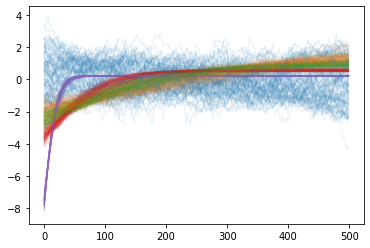

In [48]:

for _ in range(100):
    for i, s in enumerate((0, 0.005, 0.01, 0.02, 0.1)):
        x = wright_fisher(5000, 500, s, start=0.5) / 5000
        plt.plot((x - x.mean()) / x.std(), color=f"C{i}", alpha=0.1, lw=1)

2


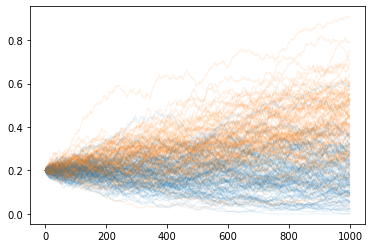

In [25]:
zeros = 0
for _ in range(100):
    for i, s in enumerate((0, 0.001)):
        x = wright_fisher(10000, 1000, s, start=0.2) / 10000
        plt.plot(x, color=f"C{i}", alpha=0.1, lw=1)
        if x[-1] == 0:
            zeros += 1
print(zeros)